# GloVe: Global Vectors for Word Representation

_This notebook demonstrates the implementation of GloVe architecture proposed by [Pennington et al., 2014](https://nlp.stanford.edu/pubs/glove.pdf) for learning continuous word representations._


**Note**: The notebook has been derived from my previously written blog post ([link](https://jaygala24.github.io/blog/python/pytorch/word-embeddings/word2vec/glove/2021/04/20/word_embeddings.html)).


Previously, there were two main directions for learning distributed word representations: 1) count-based methods such as Latent Semantic Analysis (LSA) 2) direct prediction-based methods such as Word2Vec. Count-based methods make efficient use of statistical information about the corpus, but they do not capture the meaning of the words like word2vec and perform poorly on analogy tasks such as _**“king - queen = man - woman”**_. On the other hand, direct prediction-based methods capture the meaning of the word semantically and syntactically using local context but fail to consider the global count statistics. This is where GloVe comes into the picture and overcomes the drawbacks of both approaches by combining them. The author proposed a global log bilinear regression model to learn embeddings based on the co-occurrence of words. Note that the GloVe does not use a neural network for learning word vectors.


Here we will be using text corpus of cleaned wikipedia articles provided by Matt Mahoney.


In [1]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
!unzip text8.zip

--2025-11-11 04:42:03--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.95.69, 16.182.66.232, 16.15.187.65, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.95.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  32.6MB/s    in 0.9s    

2025-11-11 04:42:04 (32.6 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


### Imports


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import time
import random
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# check if gpu is available since training is faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Preprocessing and Loading


#### Co-occurrence matrix

The authors used a co-occurrence matrix with a context window of fixed size $m$ to learn the word embeddings. Let's try to generate this matrix for the below toy example with a context window of size 2:
- I like deep learning
- I like NLP
- I enjoy flying


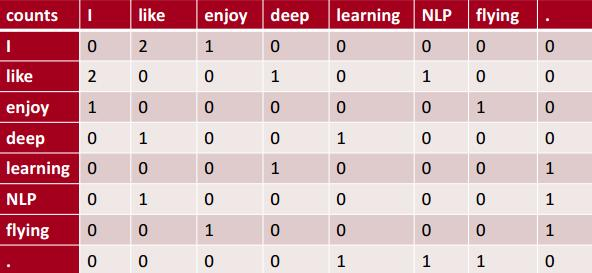

(image source: https://stanford.io/3n4FH4H)


In [7]:
class GloVeDataset(object):
    def __init__(self, corpus, min_count=5, window_size=5):
        """ Prepares the training data for the glove model.
            Params:
                corpus (string): corpus of words
                min_count (int): words with minimum occurrence to consider
                window_size (int): context window size for generating co-occurrence matrix
        """
        self.window_size = window_size
        self.min_count = min_count

        tokens = corpus.split(" ")
        word_counts = Counter(tokens)
        # only consider the words that occur more than 5 times in the corpus
        word_counts = Counter({word:count for word, count in word_counts.items() if count >= min_count})

        self.word2idx = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # create the training corpus
        self.token_ids = [self.word2idx[word] for word in tokens if word in self.word2idx]

        # create the co-occurrence matrix for corpus
        self.create_cooccurrence_matrix()


    def create_cooccurrence_matrix(self):
        """ Creates the co-occurence matrix of center and context words based on the context window size.
        """
        cooccurrence_counts = defaultdict(Counter)
        for current_idx, word in enumerate(self.token_ids):
            # find the start and end of context window
            left_boundary = max(current_idx - self.window_size, 0)
            right_boundary = min(current_idx + self.window_size + 1, len(self.token_ids))

            # obtain the context words and center words based on context window
            context_word_ids = self.token_ids[left_boundary:current_idx] + self.token_ids[current_idx + 1:right_boundary]
            center_word_id = self.token_ids[current_idx]

            for idx, context_word_id in enumerate(context_word_ids):
                if current_idx != idx:
                    # add (1 / distance from center word) for this pair
                    cooccurrence_counts[center_word_id][context_word_id] += 1 / abs(current_idx - idx)

        # create tensors for input word ids, output word ids and their co-occurence count
        in_ids, out_ids, counts = [], [], []
        for center_word_id, counter in cooccurrence_counts.items():
            for context_word_id, count in counter.items():
                in_ids.append(center_word_id)
                out_ids.append(context_word_id)
                counts.append(count)

        self.in_ids = torch.tensor(in_ids, dtype=torch.long)
        self.out_ids = torch.tensor(out_ids, dtype=torch.long)
        self.cooccurrence_counts = torch.tensor(counts, dtype=torch.float)


    def get_batches(self, batch_size):
        """ Creates the batches for training the network.
            Params:
                batch_size (int): size of the batch
            Returns:
                batch (torch tensor of shape (batch_size, 3)): tensor of word pair ids and
                    co-occurence counts for a given batch
        """
        random_ids = torch.tensor(np.random.choice(len(self.in_ids), len(self.in_ids), replace=False), dtype=torch.long)

        for i in range(0, len(random_ids), batch_size):
            batch_ids = random_ids[i: i+batch_size]
            yield self.in_ids[batch_ids], self.out_ids[batch_ids], self.cooccurrence_counts[batch_ids]


In [8]:
# read the file and initialize the GloVeDataset
with open("text8", encoding="utf-8") as f:
    corpus = f.read()

dataset = GloVeDataset(corpus)

### GloVe Model

Before we move ahead, let's get familiarized with some notations.
- $X$ denotes the word-word co-occurrence matrix
- $X_{ij}$ denotes the number of times word $j$ occurs in the context of word $i$
- $X_i$ = $\sum_{k}{X_{ik}}$ denotes the number of times any word $k$ appearing in context of word $i$ and $k$ represents the total number of distinct words that appear in context of word $i$)
- $P_{ij} = P(j | i) = \frac{X_{ij}}{X_i}$ denotes the co-occurence probablity i.e. probability that word $j$ appears in the context of word $i$

The denominator term in the co-occurrence probability accounts for global statistics, which word2vec does not uses. The main idea behind the GloVe is to encode meaning using the ratios of co-occurrence probabilities. Let's understand the above by deriving the linear meaning components for the following words based on co-occurrence probability.


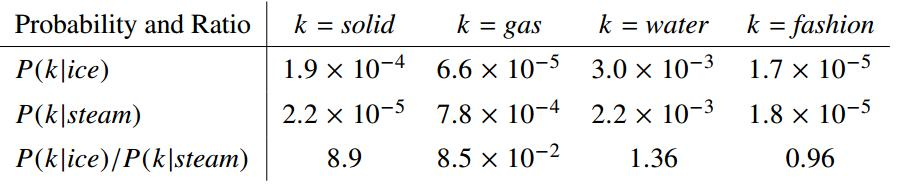

(image source: http://nlp.stanford.edu/pubs/glove.pdf)


The matrix shows the co-occurrence probabilities for the words from the concept of the thermodynamic phases of water (i.e., $ice$ and $steam$). The first two rows represent the co-occurrence probabilities for the words $ice$ and $steam$, whereas the last row represents their ratios. We can observe the following:
- ratio is not neural for closely related words such as $solid$ and $ice$ or $gas$ and $steam$
- ratio is neutral for words relevant to $ice$ and $steam$ both or not completely irrelevant to both

The ratio of co-occurrence proababilities is a good starting point for learning word embeddings. Let's start with the most general function $F$ parametrized by 3 word vectors ($w_i$, $w_j$ and $\tilde{w_k}$) given below:

$$
F(w_i, w_j, \tilde{w_k}) = \frac{P_{ik}}{P_{jk}}
$$

where $w, \tilde{w} \in \mathrm{R^d}$ and $\tilde{w}$ represent the separate context words.

How do we choose $F$?

There can be many possibilities for choosing $F$ but imposing some constraints allows us to restrict $F$ and select a unique choice. The goal is to learn word vectors (embeddings) that can be projected in the word vector space. These vector spaces are inherently linear, i.e., think of vectors as a line in $\mathrm{R^d}$ space, so the most intuitive way is to take vector differences which makes our function $F$ as follows:

$$
F(w_i - w_j, \tilde{w_k}) = \frac{P_{ik}}{P_{jk}}
$$

We see that the right-hand side of the above equation is a scalar. Choosing a complex function such as a neural network would introduce non-linearities since our primary goal is to capture the linear meaning components from word vector space. Here, we take dot product on the left-hand side to make it a scalar similar to the right-hand side.

$$
F((w_i - w_j)^T \tilde{w_k}) = \frac{P_{ik}}{P_{jk}}
$$

We also need to preserve symmetry for the distinction between a word and a context word which means that if $ice$ can be used as a context word for $water$, then $water$ can also be used as a context word for $ice$. In a simple, it can be expressed as $w \leftrightarrow \tilde{w}$. This is also evident from our co-occurrence matrix since $X \leftrightarrow X^T$. In order to restore the symmetry, we require that function $F$ is a homomorphism between groups $(\mathrm{R, +})$ and $(\mathrm{R, \times})$.

> _Given two groups, $\small (G, ∗)$ and $\small (H, \cdot)$, a group homomorphism from $\small (G, ∗)$ to $\small (H, \cdot)$ is a function $\small h : G \rightarrow H$ such that for all $u$ and $v$ in $\small G$ it holds that $\small h(u * v) = h(u) \cdot h(v)$_

$$
\begin{align}
F((w_i - w_j)^T \tilde{w_k}) &= F(w_i^T \tilde{w_k} + (-w_j^T \tilde{w_k})) \\
                            &= F(w_i^T \tilde{w_k}) \times F(-w_j^T \tilde{w_k}) \\
                            &= F(w_i^T \tilde{w_k}) \times F(w_j^T \tilde{w_k})^{-1} \\
                            &= \frac{F(w_i^T \tilde{w_k})}{F(w_j^T \tilde{w_k})} \\
\end{align}
$$

So if we recall the $F$ in terms of co-occurrence probabilities, we get the following:

$$
F(w_i^T \tilde{w_k}) = P_{ik} = \frac{X_{ik}}{X_i}
$$

Since we are expressing $F$ in terms of probability which is a non-negative term, so we apply exponential to dot product $w_i^T \tilde{w_k}$ and then take logarithm on both sides.

$$
w_i^T \tilde{w_k} = log(P_{ik}) = log(X_{ik}) - log(X_i)
$$

On the right hand, the term $log(X_i)$ is independent of $k$ so it can be absorbed into a bias $b_i$ for $w_i$. Finally, we add bias $\tilde{b_k}$ for $\tilde{w_k}$ to restore the symmetry.

$$
w_i^T \tilde{w_k} + b_i + \tilde{b_k} = log(X_{ik})
$$

The above equation leads to our objective function, a weighted least squares regression model where we use the weighting function $f(X_{ij})$ for word-word co-occurrences.

$$
J = \sum_{i,j = 1}^{V}f(X_{ij}) (w_i^T \tilde{w_k} + b_i + \tilde{b_k} - logX_{ik})^2
$$

where $V$ is the size of the vocabulary.

Here, the weighting function is defined as follows:

$$
f(x) = \begin{cases}
        (x / x_{max})^{\alpha} & \text{if}\ x < x_{max} \\
        1 & \text{otherwise}
       \end{cases}
$$

where $x_{max}$ is the cutoff of the weighting function and $\alpha$ is power scaling similar to Word2Vec.


In [11]:
class GloVeModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, x_max=100, alpha=0.75):
        """ GloVe model for learning word embeddings. Uses the approach of predicting
            context words given the center word.
            Params:
                vocab_size (int): number of words in the vocabulary
                embed_dim (int): embeddings of dimension to be generated
                x_max (int): cutoff of the weighting function
                alpha (int): parameter of the weighting funtion
        """
        super(GloVeModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.x_max = x_max
        self.alpha = alpha

        # embedding layers for input (center) and output (context) words along with biases
        self.embed_in = nn.Embedding(vocab_size, embed_dim)
        self.embed_out = nn.Embedding(vocab_size, embed_dim)
        self.bias_in = nn.Embedding(vocab_size, 1)
        self.bias_out = nn.Embedding(vocab_size, 1)

        # initialize the embeddings with uniform dist and set bias to zero
        self.embed_in.weight.data.uniform_(-1, 1)
        self.embed_out.weight.data.uniform_(-1, 1)
        self.bias_in.weight.data.zero_()
        self.bias_out.weight.data.zero_()


    def forward(self, in_ids, out_ids, cooccurrence_counts):
        """ Trains the GloVe model and updates the weights based on the
            criterion.
            Params:
                in_ids (torch tensor of shape (batch_size,)): indexes of the input words for a batch
                out_ids (torch tensor of shape (batch_size,)): indexes of the output words for a batch
                cooccurrence_counts (torch tensor of shape (batch_size,)): co-occurence count of input
                    and output words for a batch
        """
        emb_in = self.embed_in(in_ids)
        emb_out = self.embed_out(out_ids)
        b_in = self.bias_in(in_ids)
        b_out = self.bias_out(out_ids)

        # add 1 to counts i.e. cooccurrences in order to avoid log(0) case
        cooccurrence_counts += 1

        # count weight factor
        weight_factor = torch.pow(cooccurrence_counts / self.x_max, self.alpha)
        weight_factor[cooccurrence_counts > 1] = 1

        # calculate the distance between the input and output embeddings
        emb_prods = torch.sum(emb_in * emb_out, dim=1)
        log_cooccurrences = torch.log(cooccurrence_counts)
        distances = (emb_prods + b_in + b_out - log_cooccurrences) ** 2

        return torch.mean(weight_factor * distances)


### Training


In [12]:
# intialize the model and optimizer
vocab_size = len(dataset.word2idx)
embed_dim = 300
model = GloVeModel(vocab_size, embed_dim).to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.05)

In [13]:
# training the network
n_epochs = 5
batch_size = 512

print("-" * 60)
print("Start of training")
print("-" * 60)

for epoch in range(n_epochs):
    losses = []
    start = time.time()

    for input_word_ids, target_word_ids, cooccurrence_counts in dataset.get_batches(batch_size):
        # load tensor to GPU
        input_word_ids = input_word_ids.to(device)
        target_word_ids = target_word_ids.to(device)
        cooccurrence_counts = cooccurrence_counts.to(device)

        # forward pass
        loss = model.forward(input_word_ids, target_word_ids, cooccurrence_counts)

        # backward pass, optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    end = time.time()

    print(f"Epochs: {epoch + 1}/{n_epochs}\tAvg training loss: {np.mean(losses):.6f}\tEllapsed time: {(end - start):.0f} s")

print("-" * 60)
print("End of training")
print("-" * 60)


------------------------------------------------------------
Start of training
------------------------------------------------------------
Epochs: 1/5	Avg training loss: 11.869215	Ellapsed time: 663 s
Epochs: 2/5	Avg training loss: 3.315389	Ellapsed time: 661 s
Epochs: 3/5	Avg training loss: 1.900039	Ellapsed time: 662 s
Epochs: 4/5	Avg training loss: 1.275871	Ellapsed time: 661 s
Epochs: 5/5	Avg training loss: 0.930937	Ellapsed time: 661 s
------------------------------------------------------------
End of training
------------------------------------------------------------


### Inference


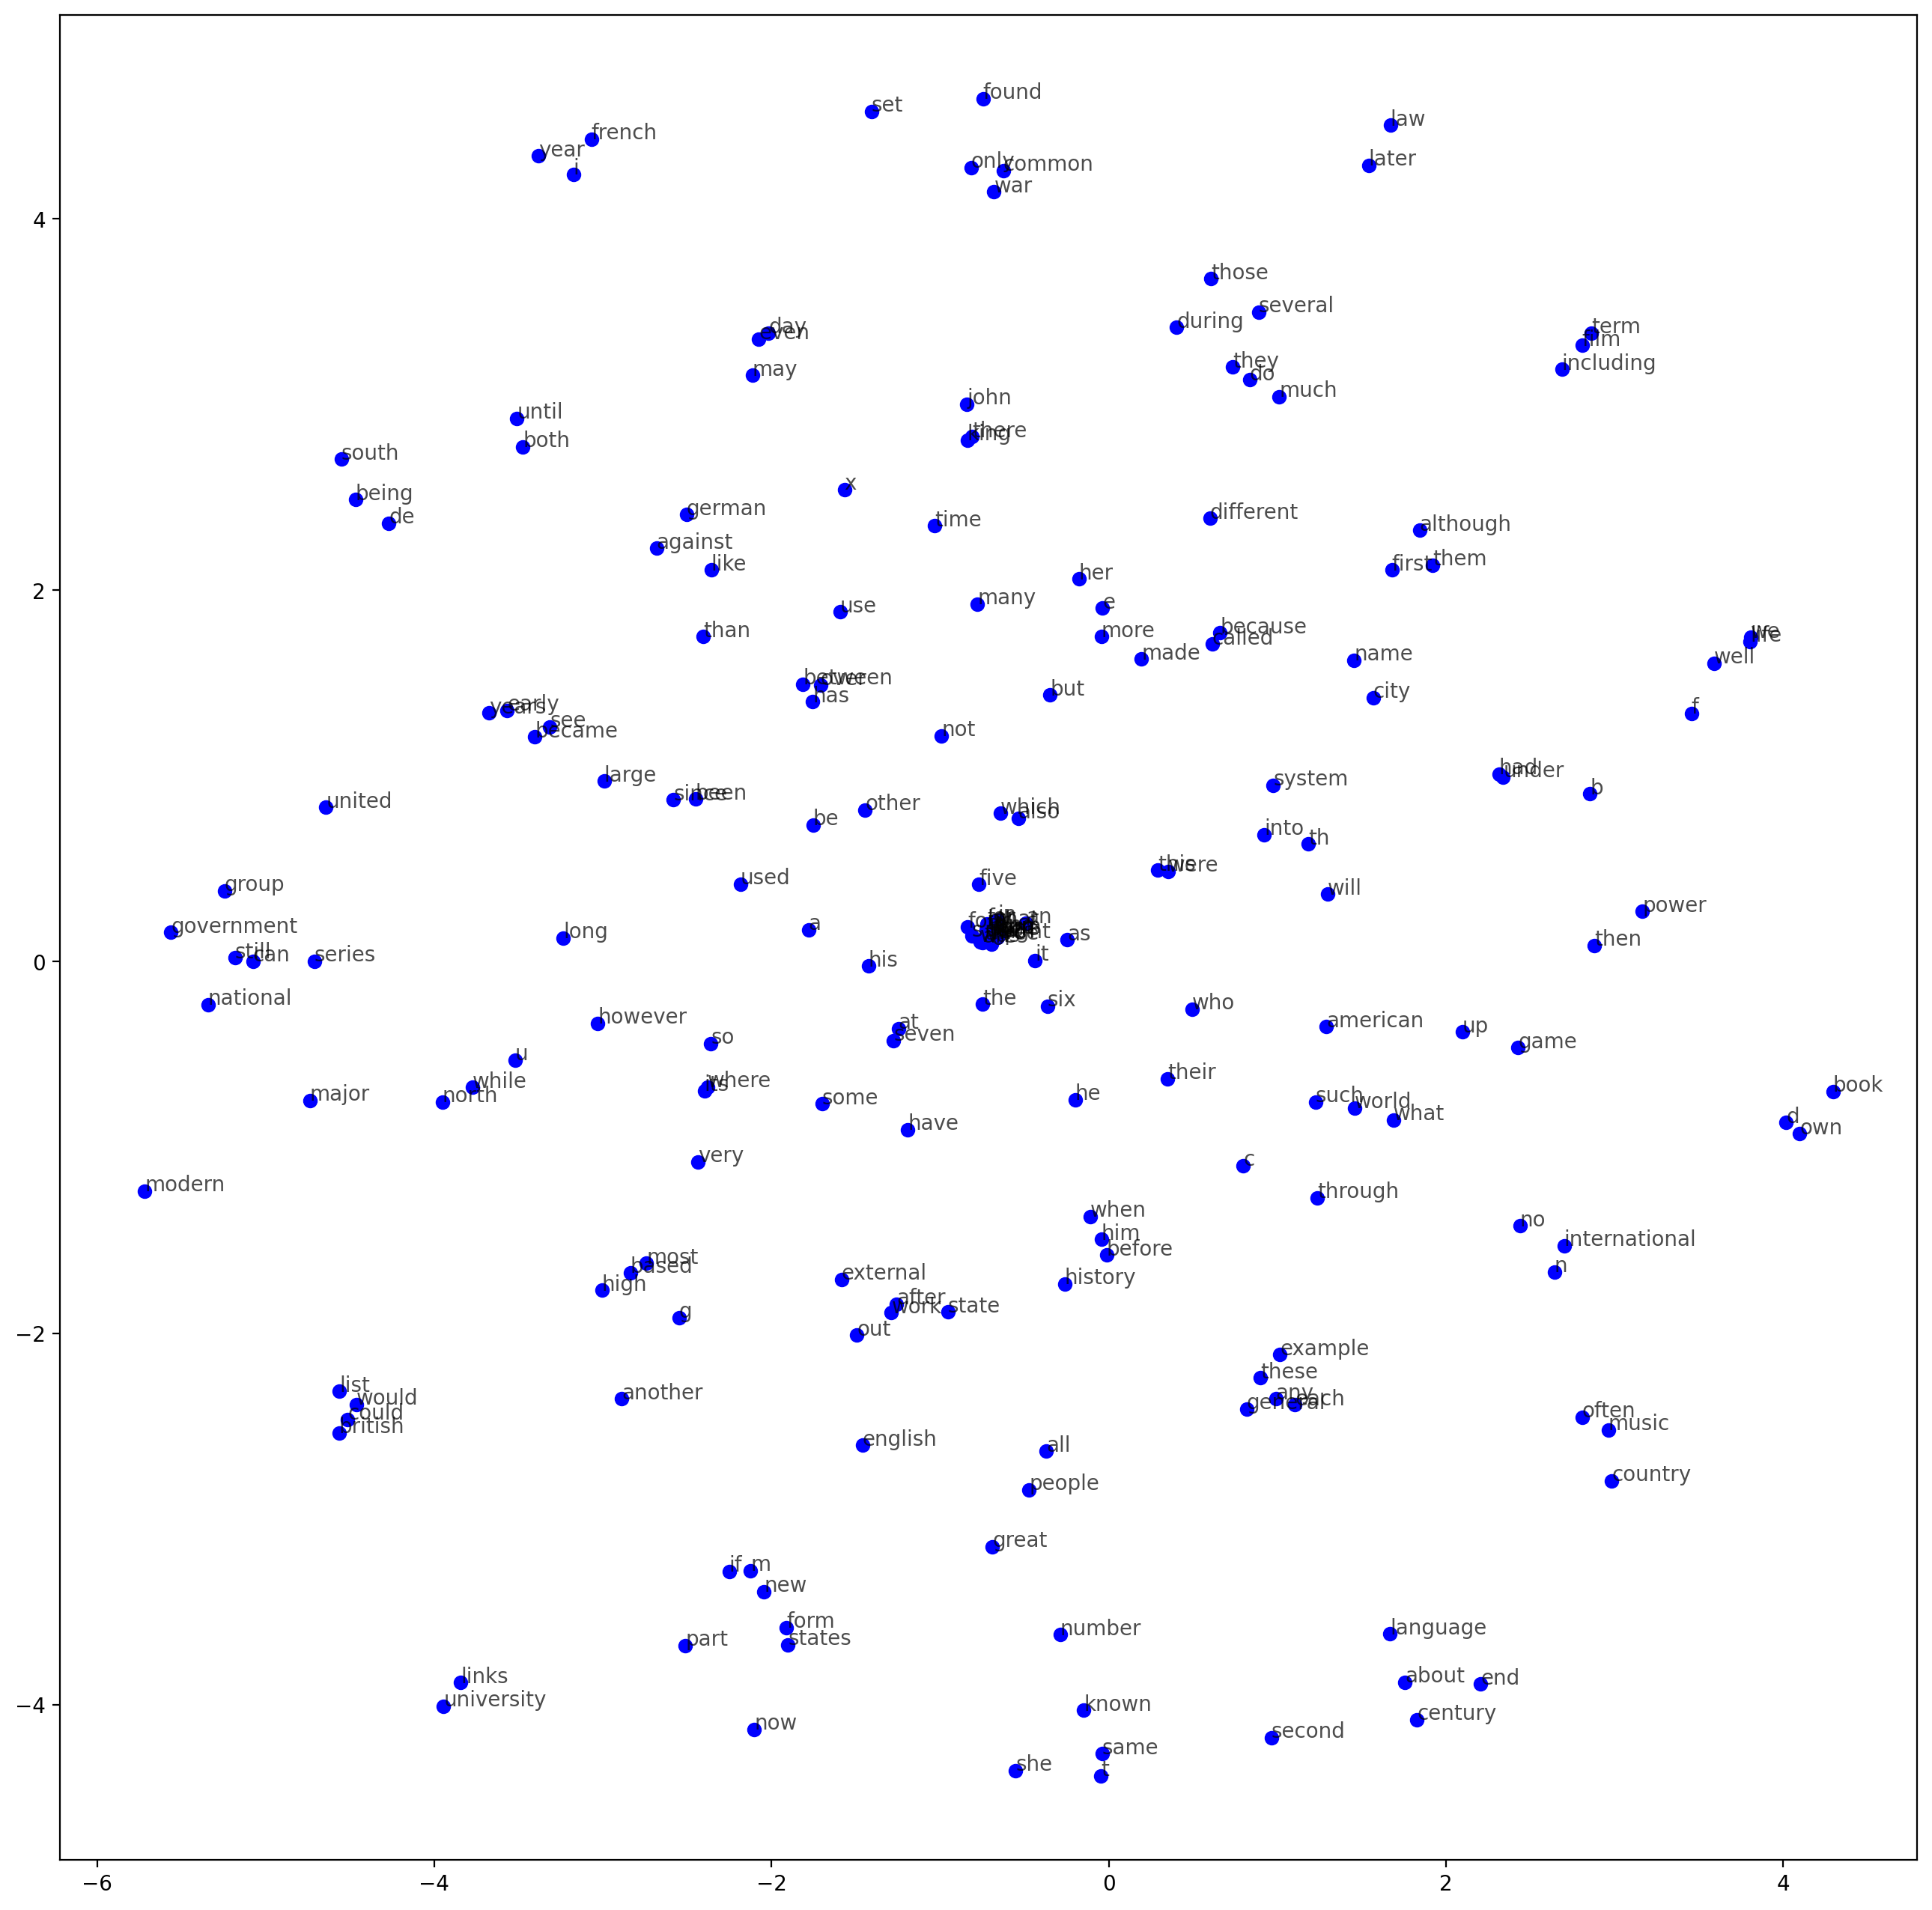

In [14]:
# get the trained embeddings from the model
emb_in = model.embed_in.weight.to("cpu").data.numpy()
emb_out = model.embed_out.weight.to("cpu").data.numpy()
embeddings = emb_in + emb_out

# number of words to be visualized
viz_words = 200

# projecting the embedding dimension from 300 to 2
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

# plot the projected embeddings
plt.figure(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color="blue")
    plt.annotate(dataset.idx2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


## References

1. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)
2. [Group homomorphism](https://en.wikipedia.org/wiki/Group_homomorphism)
3. [Homomorphism in GloVe](https://datascience.stackexchange.com/questions/27042/glove-vector-representation-homomorphism-question)
4. [A GloVe Implementation in Python](http://www.foldl.me/2014/glove-python/)
5. [Pytorch Global Vectors for Word Representation](https://github.com/kefirski/pytorch_GloVe)
